In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import ast
import statsmodels.stats.diagnostic as dg
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Import the data

In [72]:
df = pd.read_csv('result_gemeente.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6508 entries, 0 to 6507
Data columns (total 72 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           6508 non-null   int64  
 1   last_scraped                 6508 non-null   object 
 2   host_id                      6508 non-null   int64  
 3   host_since                   6508 non-null   object 
 4   host_is_superhost            6508 non-null   int64  
 5   neighbourhood_cleansed       6508 non-null   object 
 6   host_listings_count          6508 non-null   int64  
 7   latitude                     6508 non-null   float64
 8   longitude                    6508 non-null   float64
 9   property_type                6508 non-null   object 
 10  room_type                    6508 non-null   object 
 11  accommodates                 6508 non-null   int64  
 12  bathrooms                    6508 non-null   float64
 13  bathrooms_text    

## Some extra cleaning

In [73]:
distance_columns = ['trainstation_distance', 'amusement_park_distance', 'swimming_pool_distance', 'cinema_distance', 'museum_distance',  
                    'supermarket_distance', 'cafe_distance', 'hotel_distance', 'restaurant_distance']

for column in distance_columns:
    df[column] = df[column].str.replace(',', '.').astype(float)

# One-hot-encoding for property category
df = pd.get_dummies(df, columns=['property_category'], prefix=['type'])

df['type_PRIVATE_ROOM'] = df['type_PRIVATE_ROOM'].astype(int)
df['type_WHOLE_PROPERTY'] = df['type_WHOLE_PROPERTY'].astype(int)

df = df.dropna(ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 73 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           6493 non-null   int64  
 1   last_scraped                 6493 non-null   object 
 2   host_id                      6493 non-null   int64  
 3   host_since                   6493 non-null   object 
 4   host_is_superhost            6493 non-null   int64  
 5   neighbourhood_cleansed       6493 non-null   object 
 6   host_listings_count          6493 non-null   int64  
 7   latitude                     6493 non-null   float64
 8   longitude                    6493 non-null   float64
 9   property_type                6493 non-null   object 
 10  room_type                    6493 non-null   object 
 11  accommodates                 6493 non-null   int64  
 12  bathrooms                    6493 non-null   float64
 13  bathrooms_text    

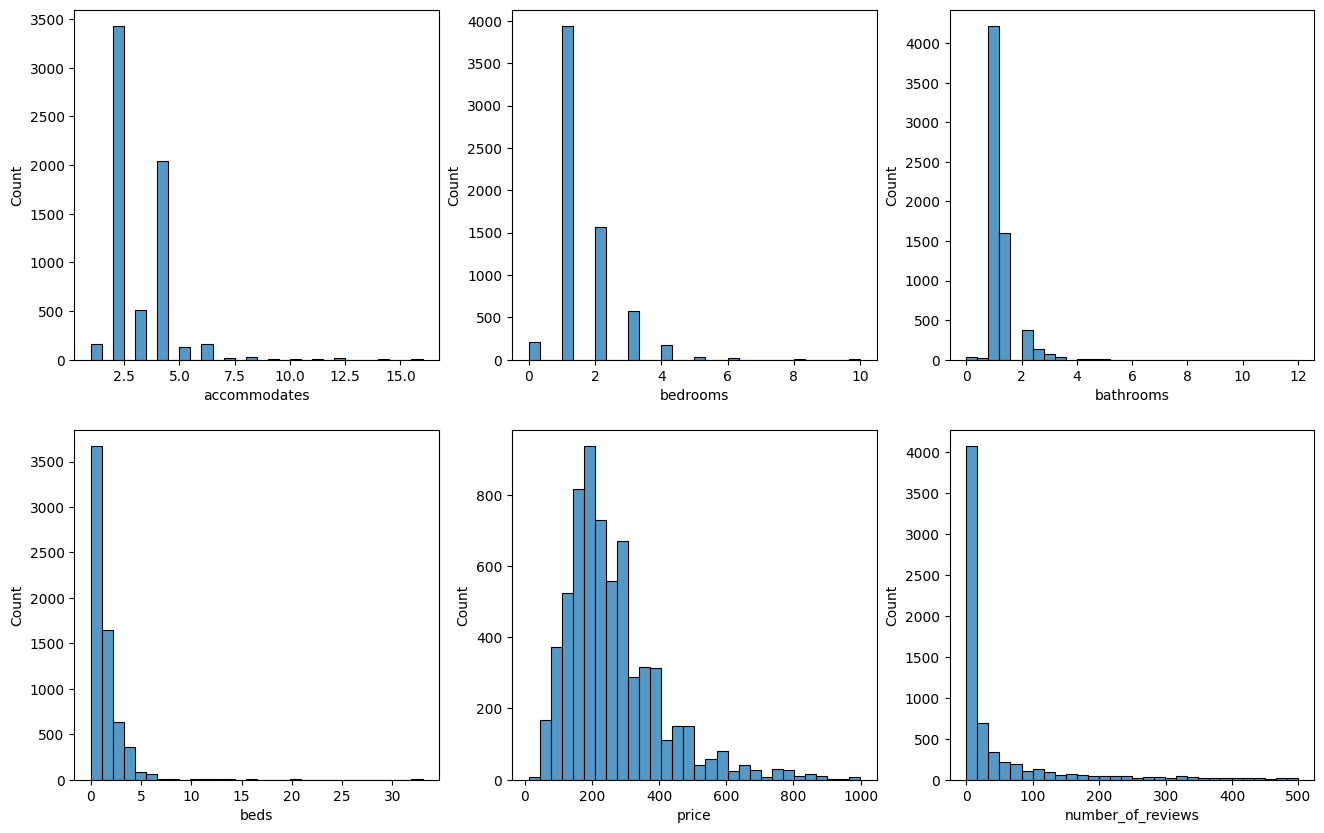

In [74]:
# Plot the histogram of some features like accommodates, bedrooms, bathrooms, beds, price and number of reviews
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
sns.histplot(df['accommodates'], ax=ax[0, 0], bins=30)
sns.histplot(df['bedrooms'], ax=ax[0, 1], bins=30)
sns.histplot(df['bathrooms'], ax=ax[0, 2], bins=30)
sns.histplot(df['beds'], ax=ax[1, 0], bins=30)
sns.histplot(df['price'], ax=ax[1, 1], bins=30)
sns.histplot(df['number_of_reviews'], ax=ax[1, 2], bins=30)
plt.show()

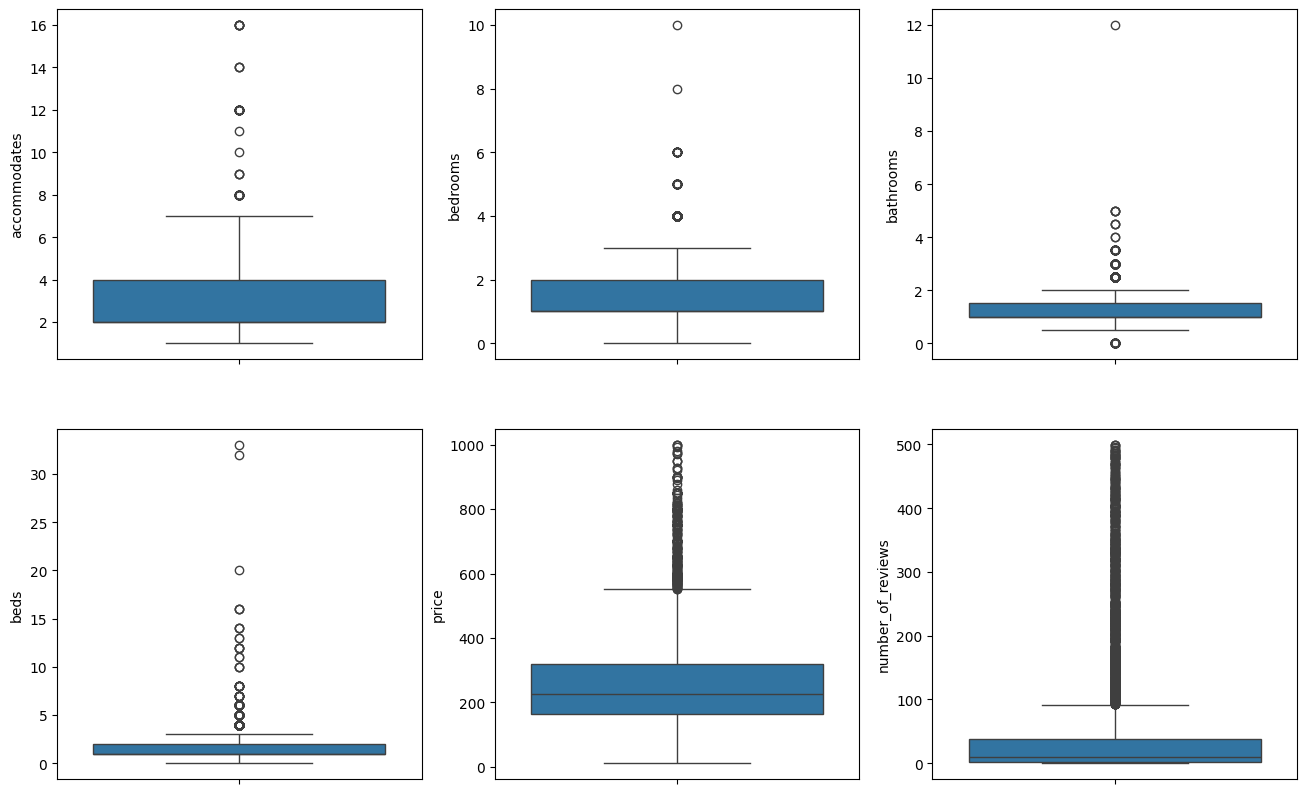

In [75]:
# Plot the boxplot of some features like accommodates, bedrooms, bathrooms, beds, price and number of reviews
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
sns.boxplot(y=df['accommodates'], ax=ax[0, 0])
sns.boxplot(y=df['bedrooms'], ax=ax[0, 1])
sns.boxplot(y=df['bathrooms'], ax=ax[0, 2])
sns.boxplot(y=df['beds'], ax=ax[1, 0])
sns.boxplot(y=df['price'], ax=ax[1, 1])
sns.boxplot(y=df['number_of_reviews'], ax=ax[1, 2])
plt.show()

### Draft 1

In [76]:
features = ["host_is_superhost", "accommodates", "bathrooms", "bedrooms", "beds", "number_of_reviews", "review_scores_rating",
            'Dishwasher', 'Washer', 'Dryer', 'Microwave', 'Freezer', 'Private entrance', 'Coffee maker', 'Oven', 'Outdoor dining area', 
            'Private patio or balcony', 'Luggage dropoff allowed', 'Bathtub', 'Blender', 'Paid parking on premises', 'Air conditioning', 
            'Waterfront', 'Pets allowed', 'Canal view', 'Free parking on premises', 'Bikes', 'Safe', 
            "residents", "average_household_income", "average_house_value", "supermarket_distance", "cafe_distance", "hotel_distance", 
            "restaurant_distance", "trainstation_distance", "amusement_park_distance", "swimming_pool_distance", "cinema_distance", "museum_distance",
            'distance_to_city_center', "type_WHOLE_PROPERTY"]

In [77]:
df[features].describe( include='all').T

,count,mean,std,min,25%,50%,75%,max
host_is_superhost,6493.0,0.210534,0.407720,0.000000,0.000000,0.000000,0.000000,1.000000e+00
accommodates,6493.0,2.931619,1.367232,1.000000,2.000000,2.000000,4.000000,1.600000e+01
bathrooms,6493.0,1.245187,0.471404,0.000000,1.000000,1.000000,1.500000,1.200000e+01
bedrooms,6493.0,1.495303,0.870293,0.000000,1.000000,1.000000,2.000000,1.000000e+01
beds,6493.0,1.722778,1.407390,0.000000,1.000000,1.000000,2.000000,3.300000e+01
number_of_reviews,6493.0,45.722316,88.614451,0.000000,2.000000,9.000000,38.000000,4.990000e+02
review_scores_rating,6493.0,4.191572,1.651373,0.000000,4.630000,4.880000,5.000000,5.000000e+00
Dishwasher,6493.0,0.526259,0.499348,0.000000,0.000000,1.000000,1.000000,1.000000e+00
Washer,6493.0,0.503927,0.500023,0.000000,0.000000,1.000000,1.000000,1.000000e+00
Dryer,6493.0,0.145695,0.352828,0.000000,0.000000,0.000000,0.000000,1.000000e+00


## Perform the linear regression on selected appropriate features

In [78]:
df['bathrooms_bathtub'] = df['bathrooms'] * df['Bathtub']
df['distance_to_center_whole_property'] = df['distance_to_city_center'] * df['type_WHOLE_PROPERTY'] # Interaction term between distance to city center and property type

In [79]:
features = features + ['bathrooms_bathtub', 'distance_to_center_whole_property']
 
X = df[features]
y = np.log(df['price']) # Log transformation of price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     160.1
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        13:37:14   Log-Likelihood:                -1834.5
No. Observations:                5194   AIC:                             3759.
Df Residuals:                    5149   BIC:                             4054.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [80]:
# Calculate MSE and R^2
X_test = sm.add_constant(X_test)
y_pred = ols_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}')
print(f'R^2: {r2}')

# Calculate Adjusted R²
n = len(y_test)
p = X_test.shape[1]
r2_adj = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
print(f'Adjusted R²: {r2_adj}')

# Calculate AIC and BIC
aic = ols_model.aic
print(f'AIC: {aic}')
bic = ols_model.bic
print(f'BIC: {bic}')

MSE: 0.11051240605915183
R^2: 0.5700658972210785
Adjusted R²: 0.5546253268898323
AIC: 3758.917233011194
BIC: 4053.9039056612155


In [81]:
# Test for heteroscedasticity
residuals = ols_model.resid
_, pval, _, _ = dg.het_breuschpagan(residuals, X_train)
print("Breusch-Pagan test p-value: ", pval)
if pval < 0.05:
    print("Heteroscedasticity detected")

Breusch-Pagan test p-value:  1.8858811631707988e-15
Heteroscedasticity detected


In [82]:
# Since we have heteroscedasticity, we will now perform the regression with WLS instead of OLS
weights = 1 / (residuals**2)
wls_model = sm.WLS(y_train, X_train, weights=weights).fit()
print(wls_model.summary())

                            WLS Regression Results                            
Dep. Variable:                  price   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.255e+05
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        13:37:19   Log-Likelihood:                 2070.4
No. Observations:                5194   AIC:                            -4051.
Df Residuals:                    5149   BIC:                            -3756.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [83]:
# Find features that have p-value less than 0.05
p_values = wls_model.pvalues
significant_features = []
for feature, p_value in zip(features, p_values[1:]):  # Skip the first p-value for the constant term
    if p_value < 0.05:
        significant_features.append(feature)

print(significant_features)
print(len(significant_features))

['host_is_superhost', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'number_of_reviews', 'review_scores_rating', 'Dishwasher', 'Washer', 'Dryer', 'Microwave', 'Private entrance', 'Coffee maker', 'Oven', 'Outdoor dining area', 'Private patio or balcony', 'Luggage dropoff allowed', 'Bathtub', 'Blender', 'Paid parking on premises', 'Air conditioning', 'Waterfront', 'Pets allowed', 'Canal view', 'Free parking on premises', 'Bikes', 'Safe', 'average_household_income', 'average_house_value', 'supermarket_distance', 'cafe_distance', 'hotel_distance', 'restaurant_distance', 'trainstation_distance', 'amusement_park_distance', 'swimming_pool_distance', 'cinema_distance', 'distance_to_city_center', 'type_WHOLE_PROPERTY', 'bathrooms_bathtub', 'distance_to_center_whole_property']
41


In [84]:
# Update the training and test sets with the selected features
X_train_new = X_train[significant_features]
X_test_new = X_test[significant_features]

X_train_new = sm.add_constant(X_train_new)
X_test_new = sm.add_constant(X_test_new)

# Refit the OLS model to calculate new weights
new_ols_model = sm.OLS(y_train, X_train_new).fit()
residuals = new_ols_model.resid
weights = 1 / (residuals**2)

# Perform WLS regression again with selected features
new_wls_model = sm.WLS(y_train, X_train_new, weights=weights).fit()
print(new_wls_model.summary())

                            WLS Regression Results                            
Dep. Variable:                  price   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.649e+05
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        13:37:24   Log-Likelihood:                 2064.0
No. Observations:                5194   AIC:                            -4044.
Df Residuals:                    5152   BIC:                            -3769.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [85]:
# Calculate MSE and R^2 for the test set
y_pred = new_wls_model.predict(X_test_new)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean squared error: ", mse)
print("R^2: ", r2)

# Get number of observations (n) and number of features (p)
n = len(y_test)  # Number of samples
p = X_test.shape[1]  # Number of features (predictors)

# Calculate Adjusted R²
r2_adj = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
print(f'Adjusted R²: {r2_adj}')

# Calculate AIC
aic = new_wls_model.aic
print(f'AIC: {aic}')
bic = new_wls_model.bic
print(f'BIC: {bic}')

Mean squared error:  0.11027879914679992
R^2:  0.5709747144466415
Adjusted R²: 0.5555667832017085
AIC: -4044.0934984256965
BIC: -3768.772603952343


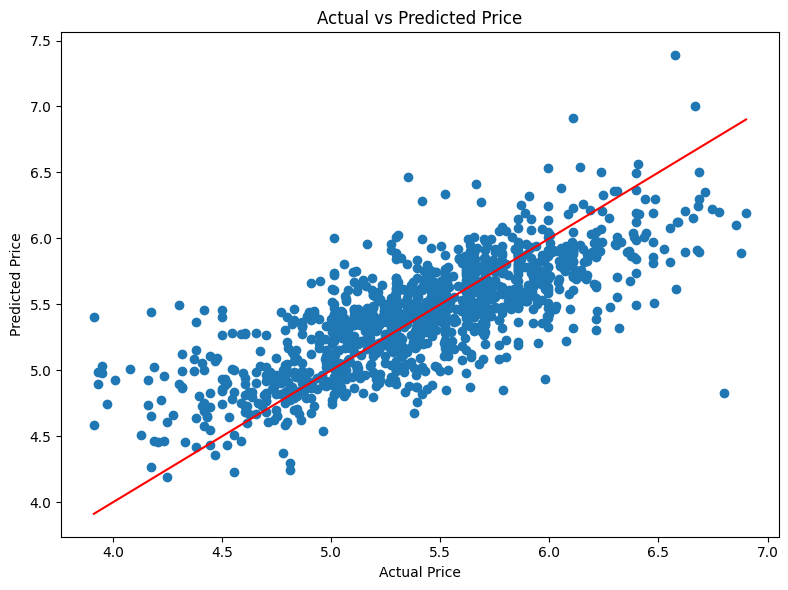

In [86]:
# Plot the actual vs predicted prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', ls='solid')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.tight_layout()
plt.show()

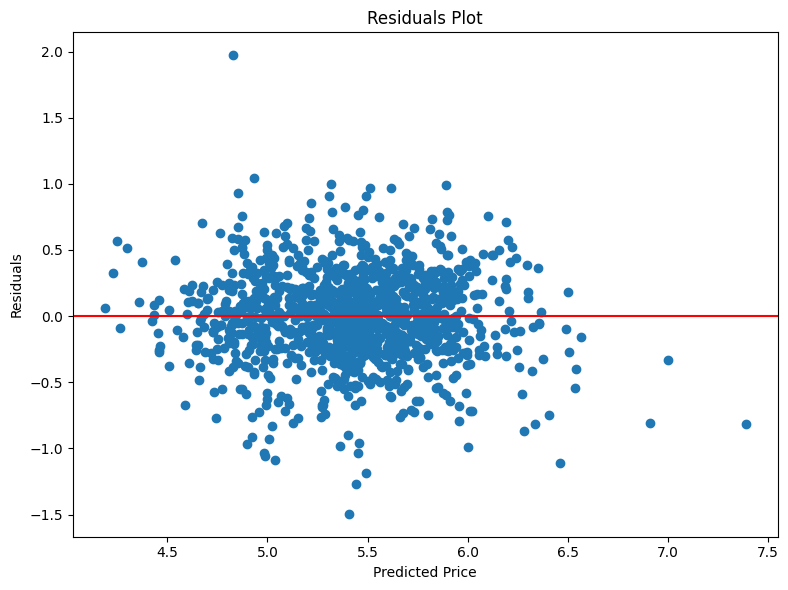

In [87]:
# Plot the residuals
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.tight_layout()
plt.show()